# HERA Data Part II : Calibration Exploration

**CHAMP Bootcamp**
<br>
**June 14, 2018**
<br>
**St. John's College, Sante Fe, NM**

In this demo we will explore HERA data, calibration solutions, and how to apply them to the data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from pyuvdata import UVData, UVCal
import hera_cal as hc
import uvtools.plot as plotter

## 1) Load the un-calibrated data into a `UVData` object

This is the `data/zen.2458116.24482.xx.HH.uvOCRU` file.

In [ ]:
# list files in current working directory
!ls

In [2]:
# load the data: this may take up to ~15 seconds...
uvd = UVData()
uvd.read_miriad("data/zen.2458116.24482.xx.HH.uvOCRU")

<IPython.core.display.Javascript object>


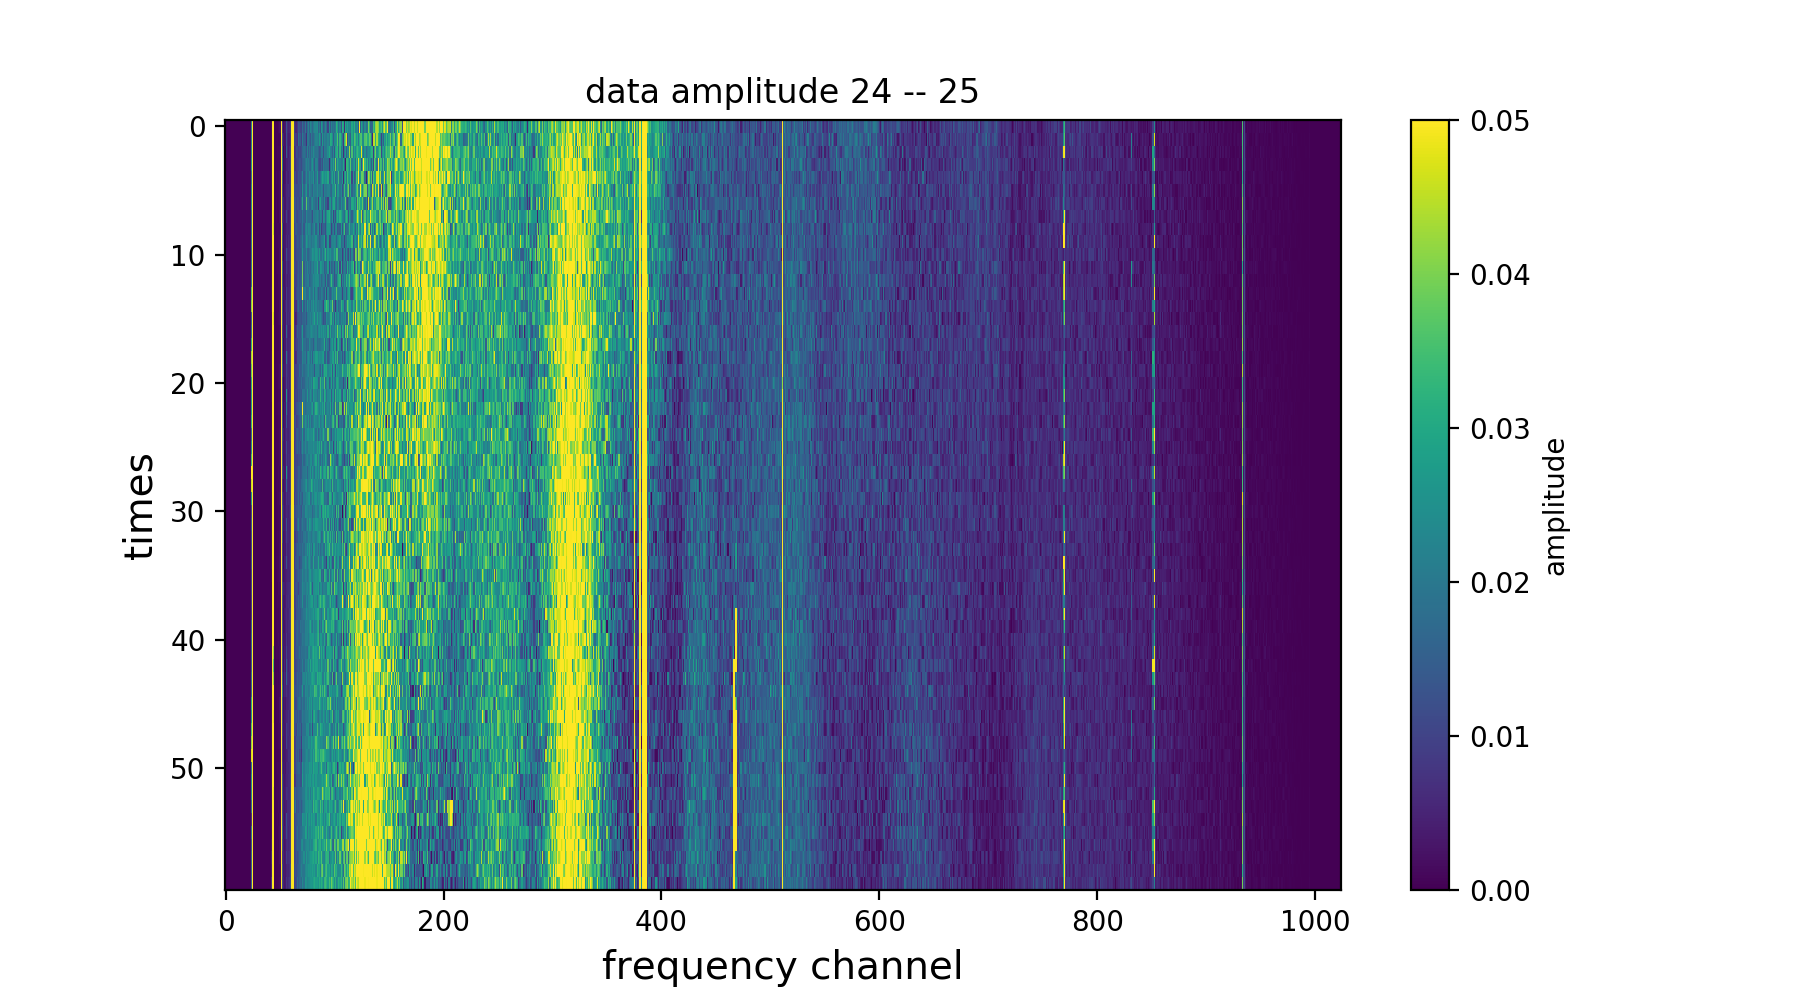

In [4]:
# make a waterfall plot of data amplitude between antenna 24 & antenna 25
plt.figure(figsize=(9, 5))
data = uvd.get_data(24, 25)
plotter.waterfall(np.abs(data), mode='real', mx=.05)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.colorbar(label='amplitude')
plt.title("data amplitude 24 -- 25")

<IPython.core.display.Javascript object>


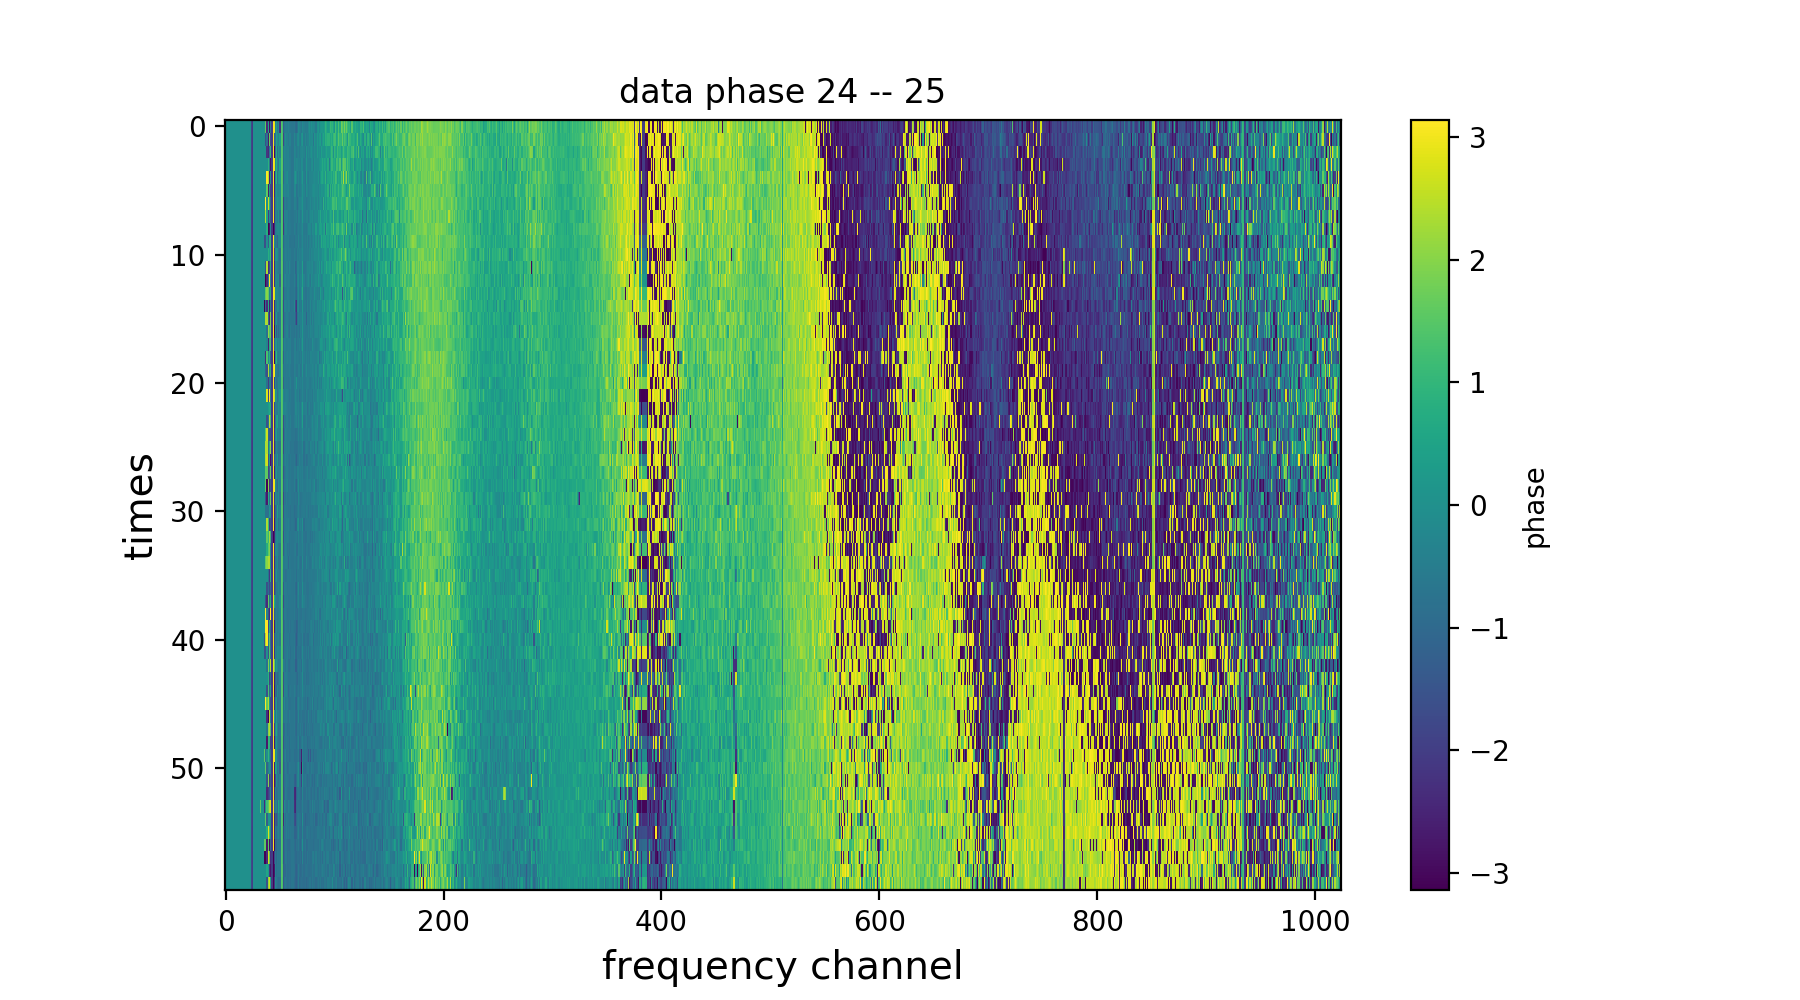

In [5]:
# make a waterfall plot of visibility phase between antenna 24 & antenna 25
# Hint 1: use np.angle
# Hint 2: use mx= kwarg to toggle maximum colorbar saturation 
plt.figure(figsize=(9, 5))
data = uvd.get_data(24, 25)
plotter.waterfall(np.angle(data), mode='real', mx=np.pi)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.colorbar(label='phase')
plt.title("data phase 24 -- 25")

## 2) Load the gain solutions into a `UVCal` object

Use the `data/zen.2458116.24482.xx.HH.uv.abs.calfits` file.

In [6]:
# load the gain solutions
uvc = UVCal()
uvc.read_calfits("data/zen.2458116.24482.xx.HH.uv.abs.calfits")

# use this function to get gains from the uvc object
def cal_get_data(uvc, ant, time=None, chan=None):
    if chan is not None:
        freq = chan
    else:
        freq = slice(None)
    if time is not None:
        assert chan is None
    else:
        time = slice(None)
    return uvc.gain_array[uvc.ant_array.tolist().index(ant), 0, freq, time, 0].T

<IPython.core.display.Javascript object>


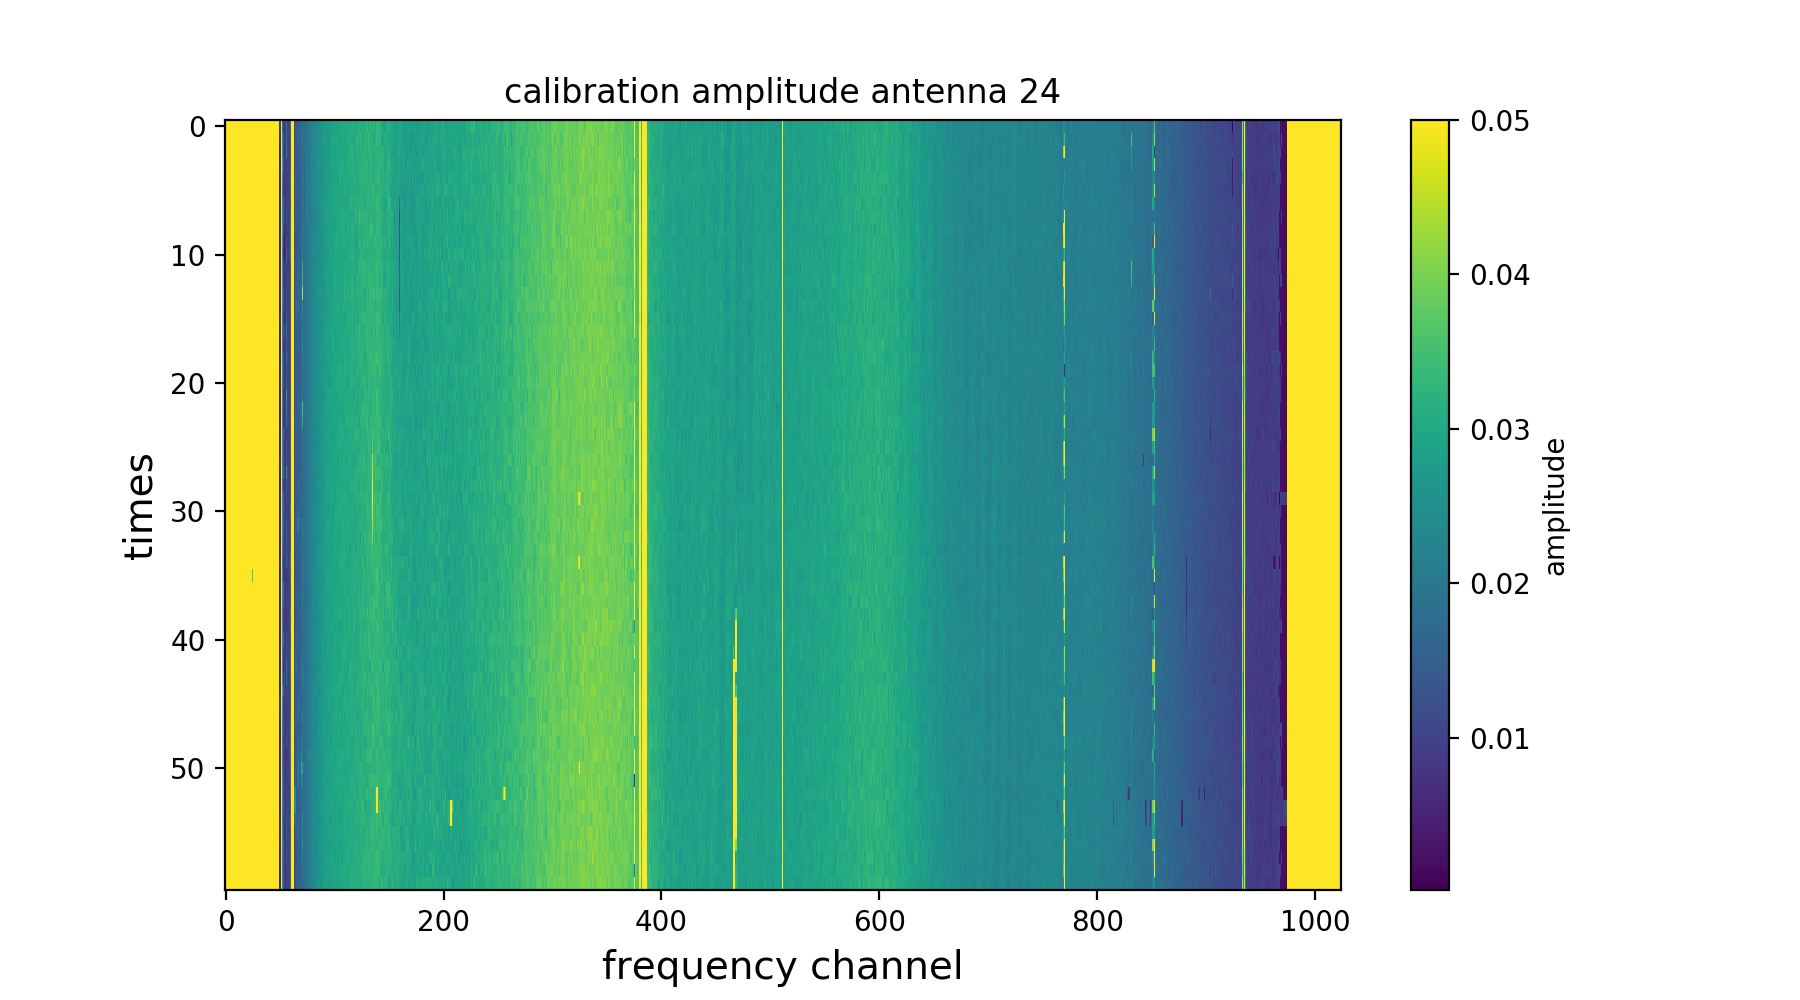

In [9]:
# make a waterfall plot of antenna 24 gain amplitude
plt.figure(figsize=(9, 5))
data = cal_get_data(uvc, 24)
plotter.waterfall(np.abs(data), mode='real', mx=.05)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.colorbar(label='amplitude')
plt.title("calibration amplitude antenna 24")

<IPython.core.display.Javascript object>


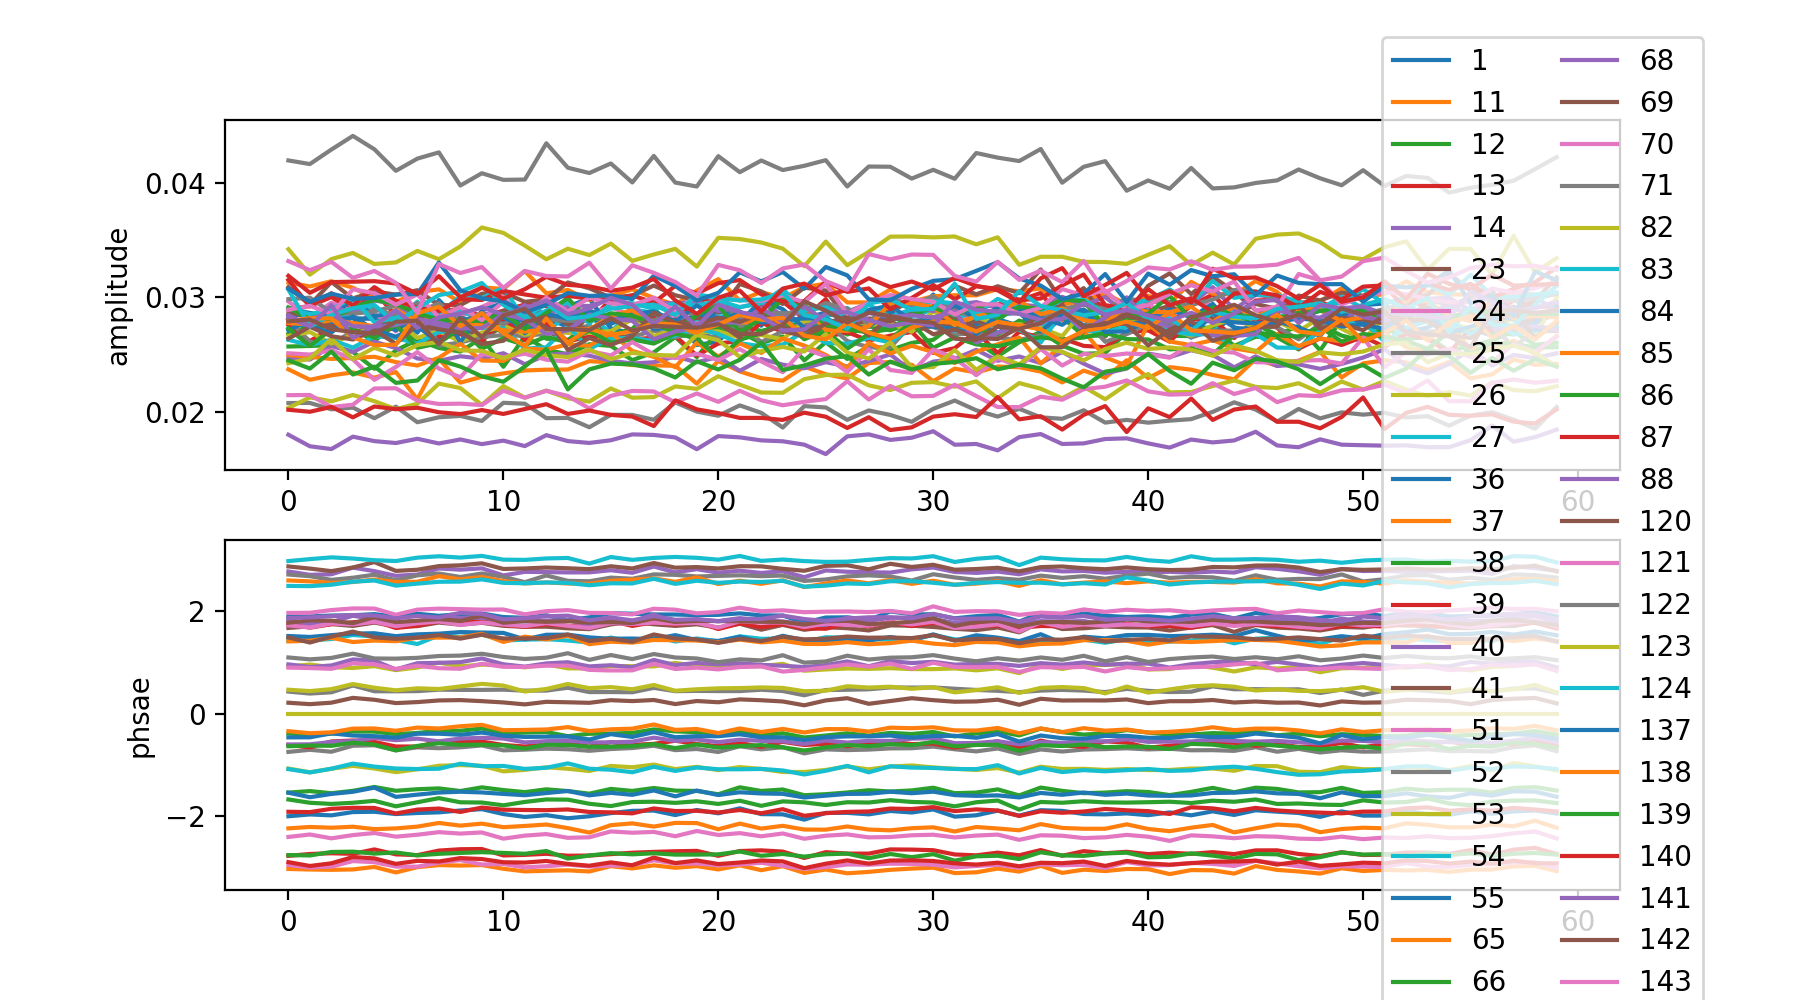

In [16]:
# make a line plot of all antenna gain amplitudes in one plot, and in another plot gain phases
# at frequency channel 512
# Hint 1: use a FOR loop over uvc.ant_array

fig = plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 2)
for ant in uvc.ant_array:
    # plot antenna phases here
    data = cal_get_data(uvc, ant, chan=512)
    plt.plot(np.angle(data))

plt.ylabel("phsae")
    
plt.subplot(2, 1, 1)
for ant in uvc.ant_array:
    # plot antenna amplitudes here
    data = cal_get_data(uvc, ant, chan=512)
    plt.plot(np.abs(data))
    
plt.ylabel("amplitude")
plt.legend(uvc.ant_array, ncol=2, borderaxespad=-3, loc=0, fontsize=10)

How much does the gain amplitude vary over the course of the file? Do certain antennas look different than others? Which ones? Hint: try changing the colormap between `magma` and `'None'` to identify antennas, ex: `cmap='magma'`.

<IPython.core.display.Javascript object>


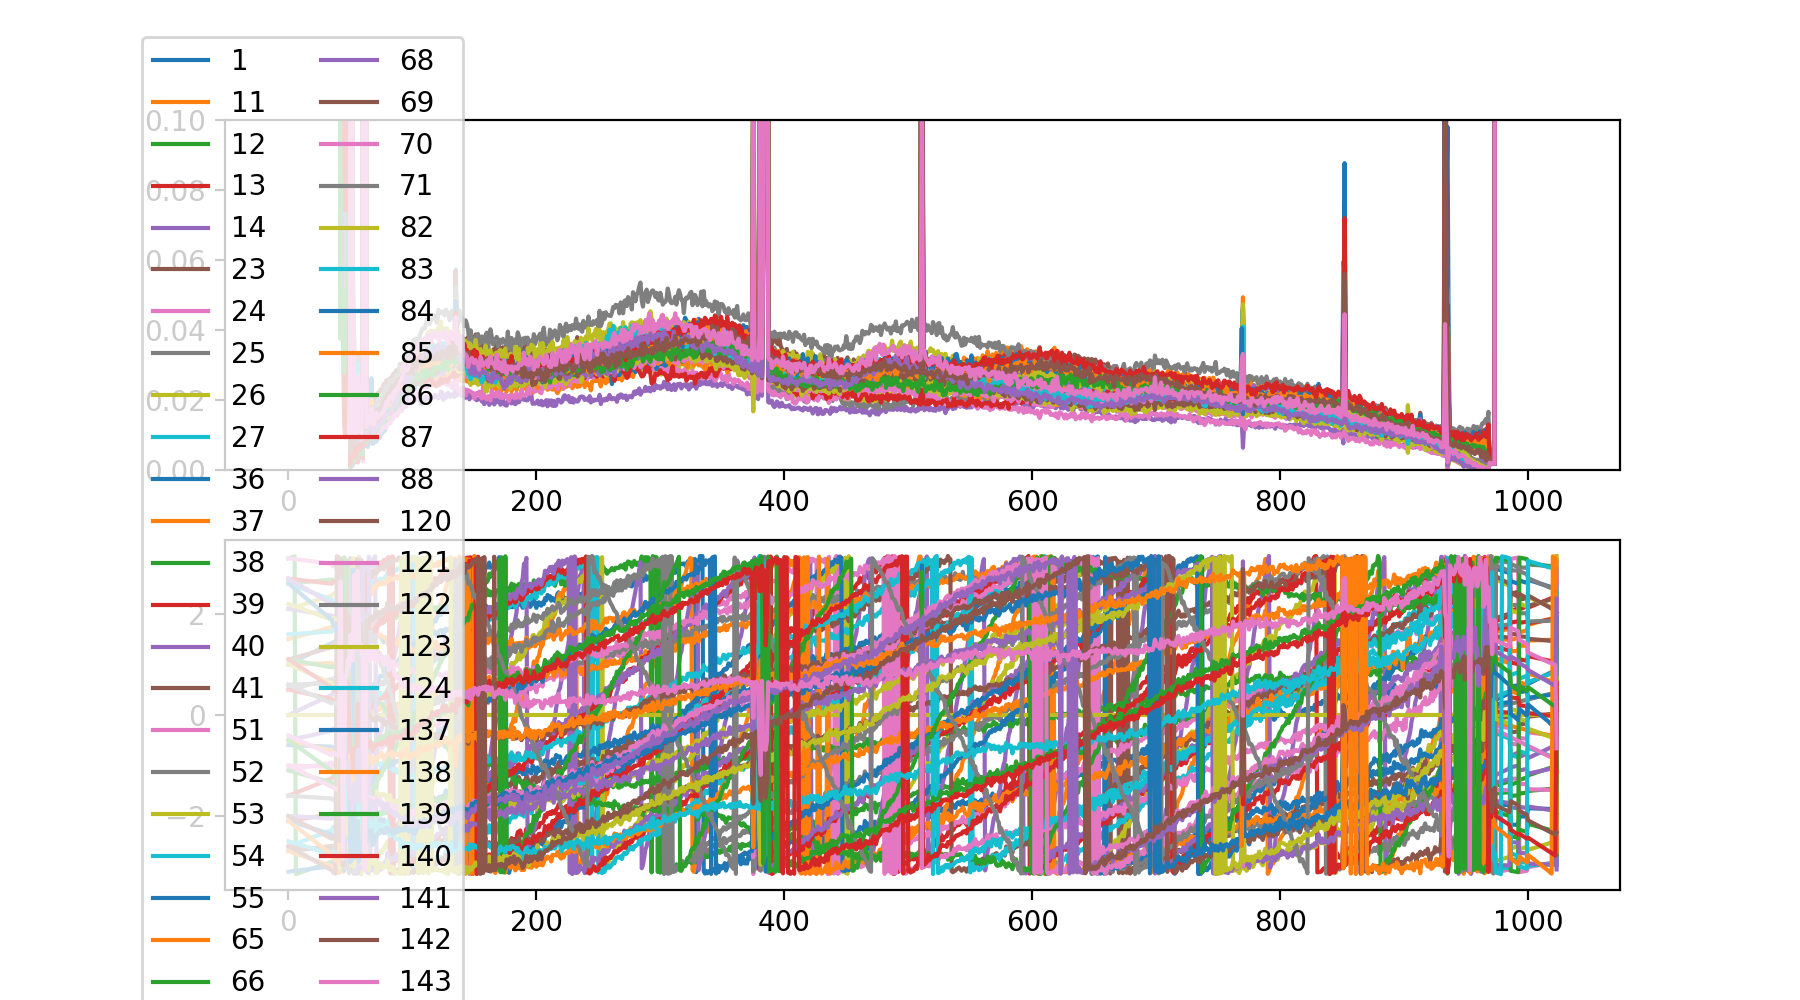

In [19]:
# make a line plot of all antenna gain amplitudes in one plot, and in another plot gain phases
# at time index 30
# Hint 1: use a FOR loop over uvc.ant_array
# Hint 2: use plt.ylim(a, b) to change y-axis range

fig = plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 2)
for ant in uvc.ant_array:
    # plot antenna phases here
    data = cal_get_data(uvc, ant, time=30)
    plt.plot(np.angle(data))
    
plt.subplot(2, 1, 1)
for ant in uvc.ant_array:
    # plot antenna amplitudes here
    data = cal_get_data(uvc, ant, time=30)
    plt.plot(np.abs(data))
    
plt.ylim(0, 0.1)
    
plt.legend(uvc.ant_array, ncol=2, borderaxespad=-3, loc=0, fontsize=10)

What do you see in the gain amplitude and phase across frequency? What might cause these features?

## 3) Load the model visibility into a `UVData` object

Use the `data/zen.2458116.24482.xx.HH.uvXRS2` file.

In [20]:
# load the model: this may take up to ~15 seconds
uvm = UVData()
uvm.read_miriad('data/zen.2458116.24482.xx.HH.uvXRS2')

<IPython.core.display.Javascript object>


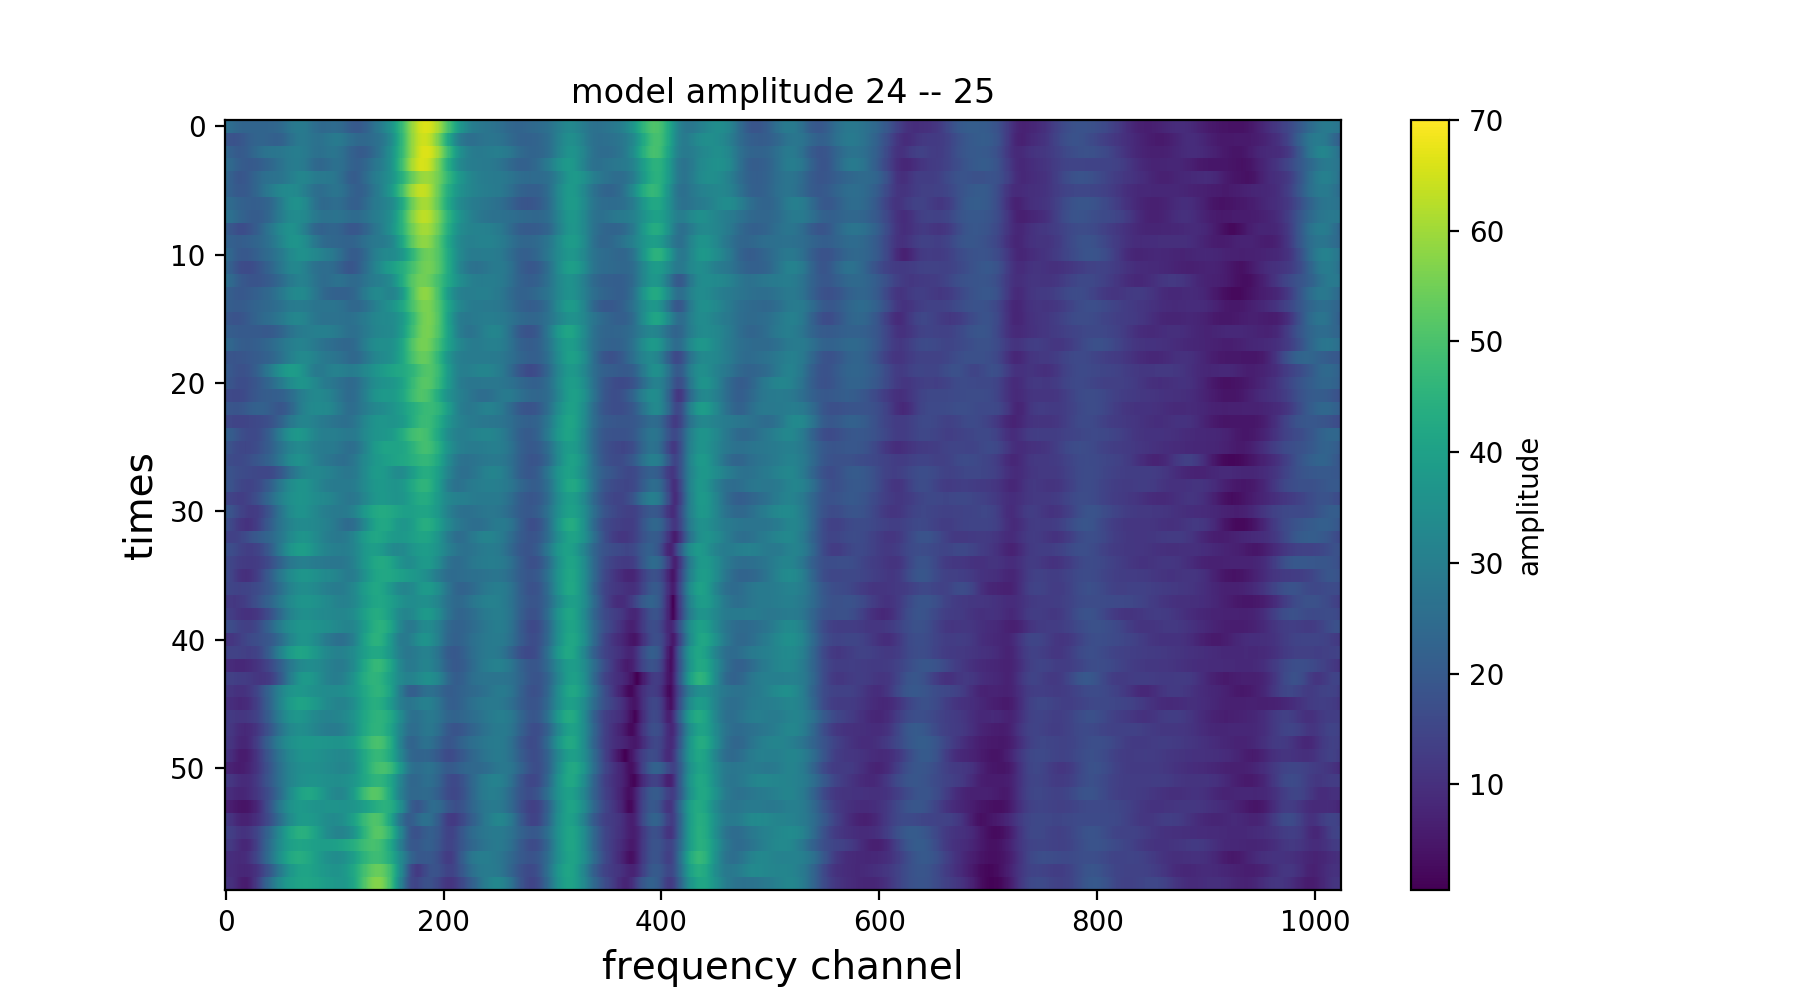

In [24]:
# make a waterfall plot of model amplitude between antenna 24 & antenna 25
plt.figure(figsize=(9, 5))
model = uvm.get_data(24, 25)
plotter.waterfall(np.abs(model), mode='real', mx=70)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.colorbar(label='amplitude')
plt.title("model amplitude 24 -- 25")

## 4) Apply the calibration gain solution

Recall that, ideally:

\begin{align}
\Large V_{ij}^{\rm data} = g_ig_j^\ast V_{ij}^{\rm model}
\end{align}

such that we can compute

\begin{align}
\Large V_{ij}^{\rm updated\ data} = V_{ij}^{\rm data} / (g_i g_j^\ast)
\end{align}

<IPython.core.display.Javascript object>


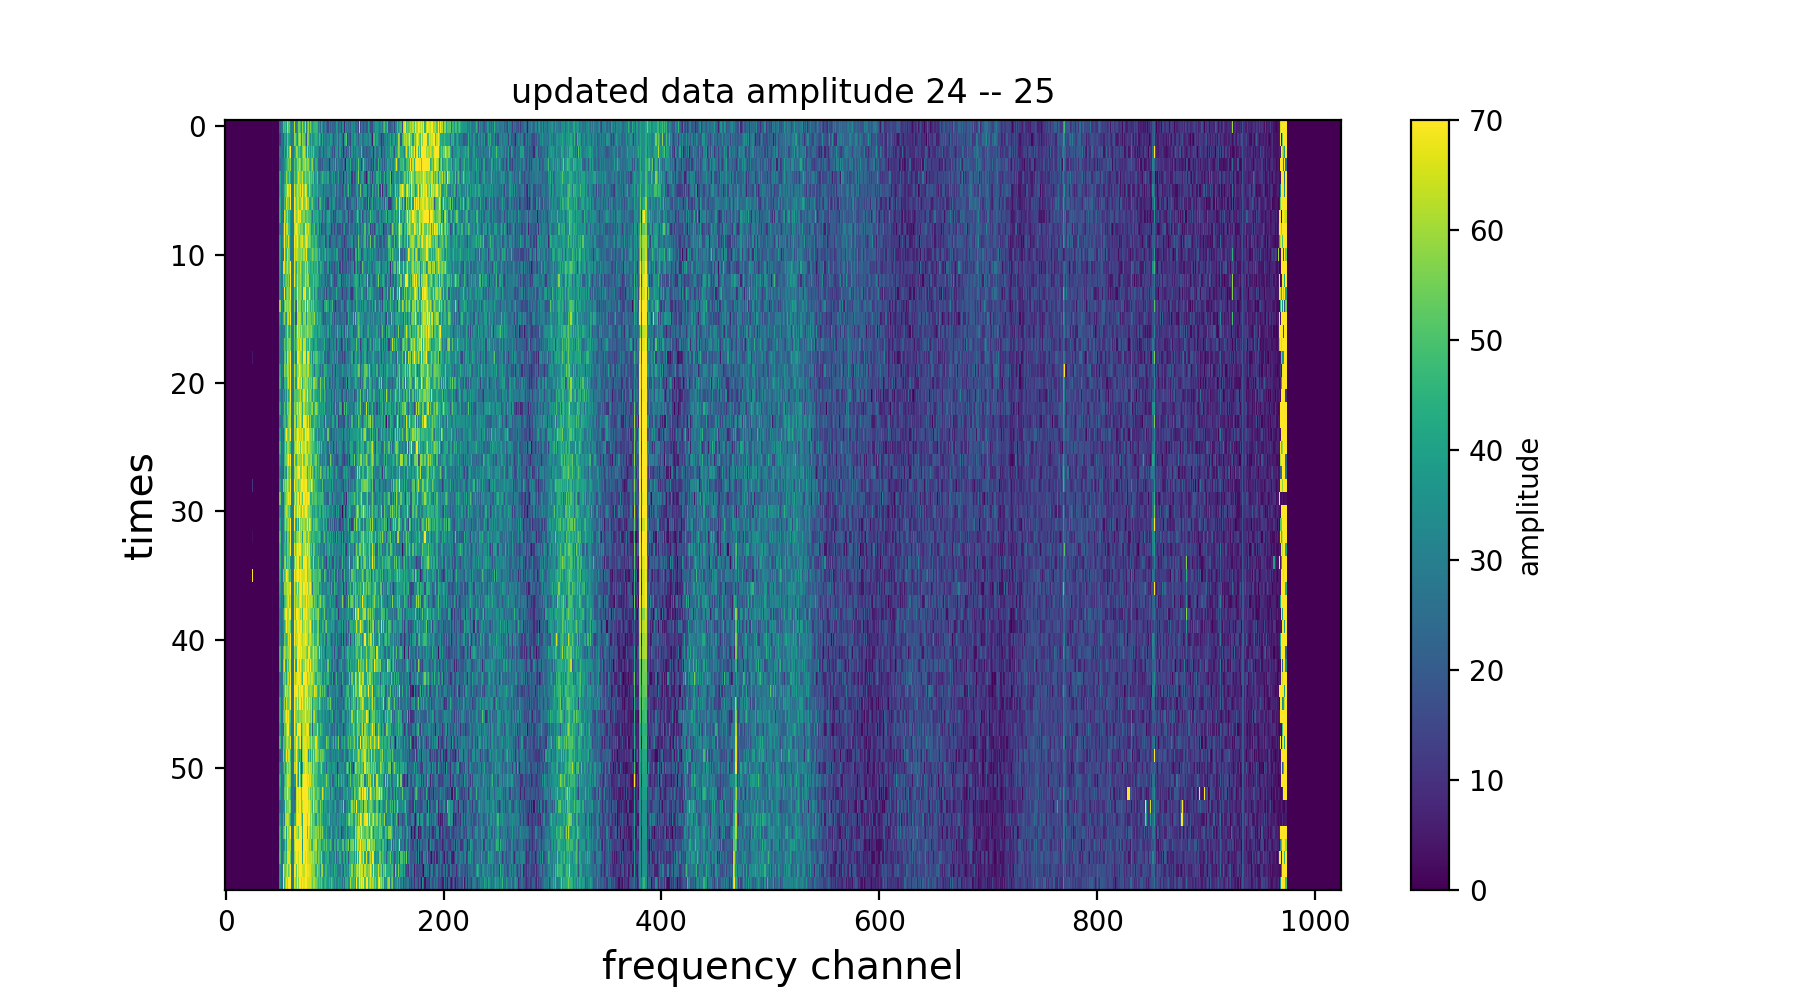

In [29]:
# apply calibration to V_24_25 and make a waterfall plot of updated data amplitude
data = uvd.get_data(24, 25)
cal = cal_get_data(uvc, 24) * np.conj(cal_get_data(uvc, 25))
updated_data = data / cal

plt.figure(figsize=(9, 5))
plotter.waterfall(np.abs(updated_data), mode='real', mx=70)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.colorbar(label='amplitude')
plt.title("updated data amplitude 24 -- 25")

<IPython.core.display.Javascript object>


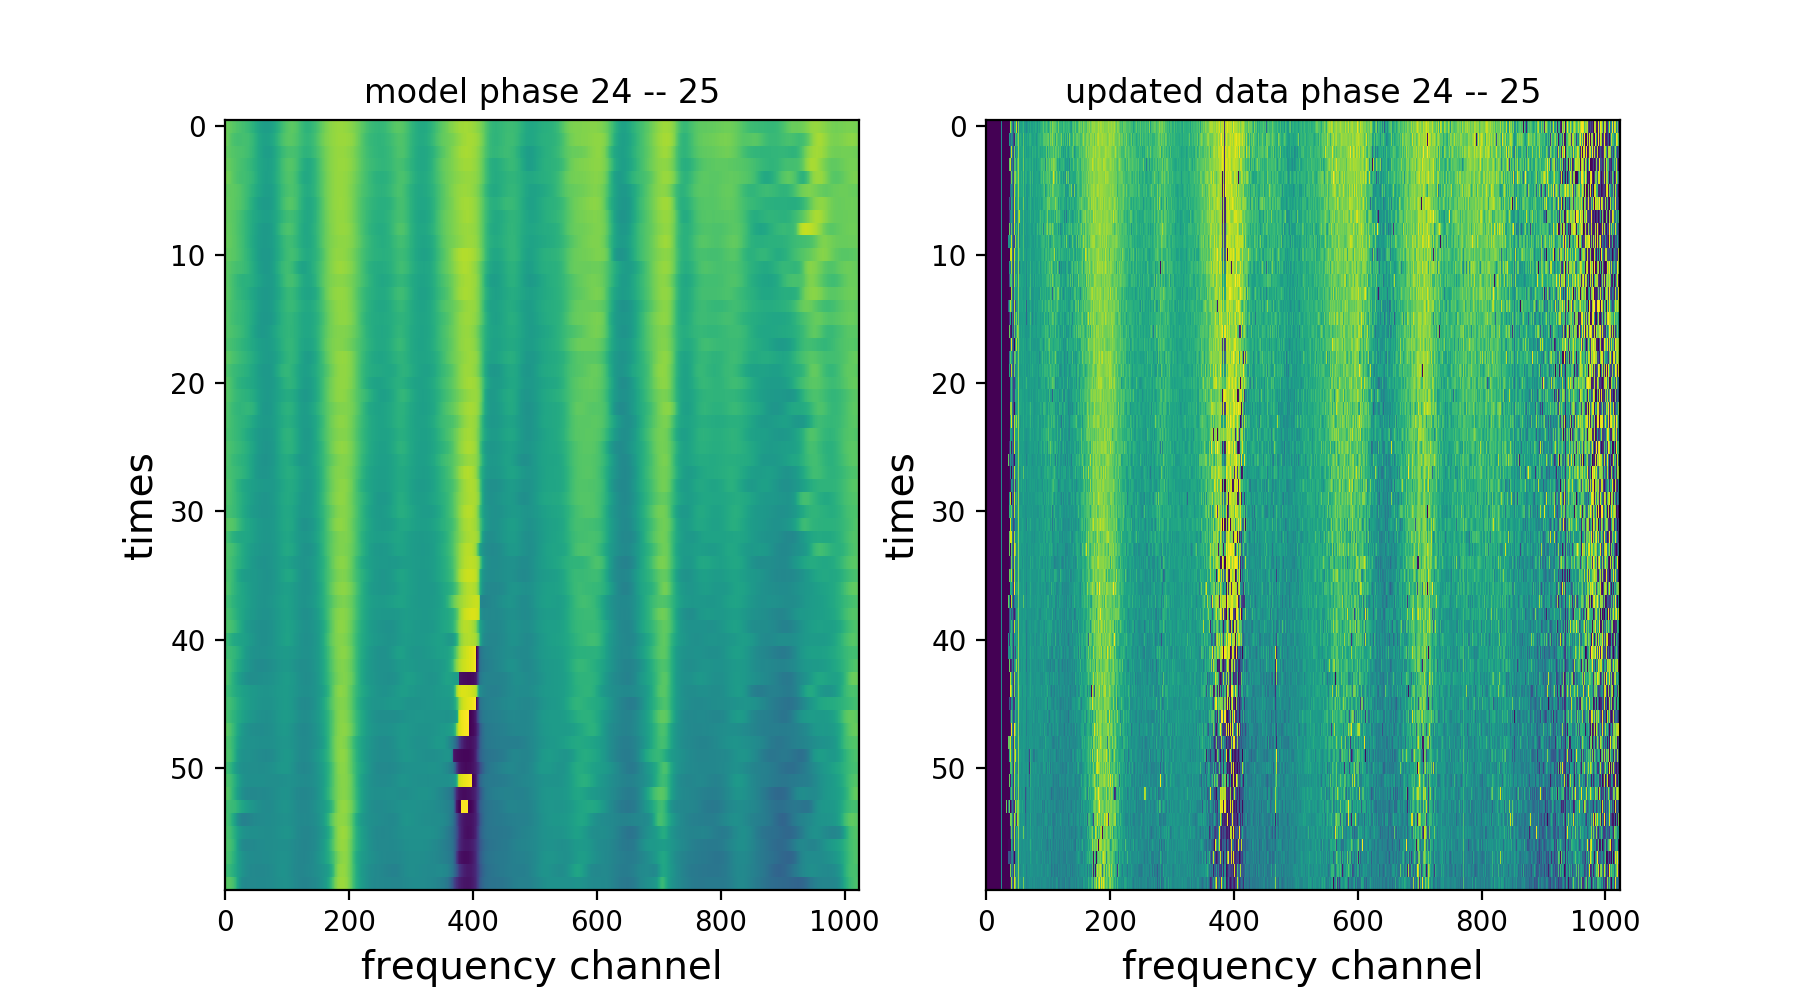

In [37]:
# plot model and updated data phase side-by-side
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
plotter.waterfall(np.angle(model), mode='real', mx=None)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.title("model phase 24 -- 25")

plt.subplot(1, 2, 2)
plotter.waterfall(np.angle(updated_data), mode='real', mx=None)
plt.xlabel('frequency channel' , fontsize=14)
plt.ylabel('times' , fontsize=14)
plt.title("updated data phase 24 -- 25")
